In [5]:
#install.packages('nycflights13')
library(tidyverse)
library(nycflights13)
library(broom)
library(modelr)  # modelr = wrapper, damit base R modeling Funktionen mit %>% benutzt werden können

options(repr.plot.width=5, repr.plot.height=3)

Installing package into ‘/usr/local/spark-2.4.3-bin-hadoop2.7/R/lib’
(as ‘lib’ is unspecified)

Attaching package: ‘modelr’

The following object is masked from ‘package:broom’:

    bootstrap



x,1.000000,1.000000,1.000000,2.000000,2.00000,2.00000,3.000000,3.00000,3.0000,4.00000,⋯,7.00000,8.0000,8.00000,8.00000,9.00000,9.00000,9.00000,10.0000,10.00000,10.0000
y,4.199913,7.510634,2.125473,8.988857,10.24311,11.29682,7.356365,10.50535,10.5116,12.43459,⋯,19.93631,21.7259,18.39091,22.47555,26.77701,22.80511,21.12831,24.9681,23.34642,21.9752


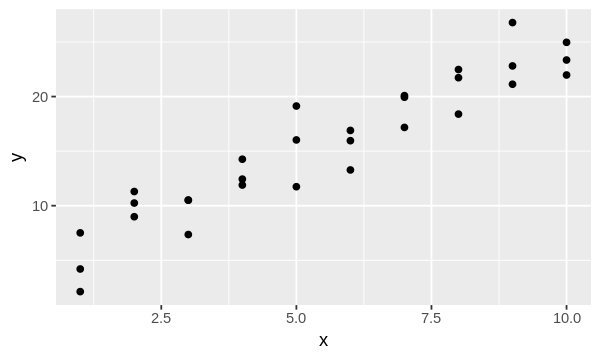

In [6]:
# Dataset
t(sim1)
ggplot(sim1, aes(x, y)) + geom_point()

# Test-Model
sim1_mod <- lm(y ~ x, data = sim1)
mod2 <- lm(y ~ x, data = sim2)

x,1.000000,2.000000,3.00000,4.00000,5.00000,6.00000,7.00000,8.00000,9.00000,10.00000
pred,6.272355,8.323888,10.37542,12.42695,14.47849,16.53002,18.58155,20.63309,22.68462,24.73615


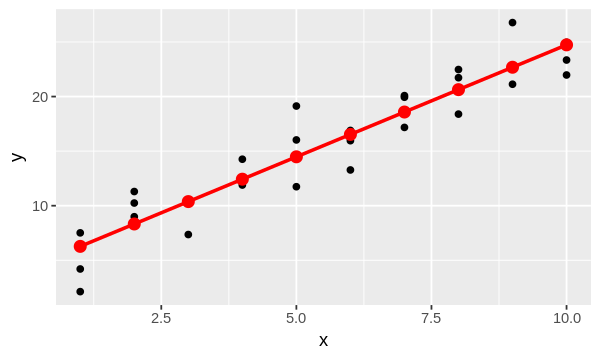

In [7]:
## PREDICTIONS VISUALISIEREN: kontinuierlich
# !!!!
# JEDE beliebige unterliegende Funktion - nicht nur linear!!!!
# !!!!
# ==> partieller Effekt (bei linear = eine Gerade)

grid <- sim1 %>% data_grid(x)                 # X Werte erzeugen
grid <- grid %>% add_predictions(sim1_mod)    # Predictions erzeugen
t(grid)

## Linearer Funktion
ggplot(sim1, aes(x)) +
  geom_point(aes(y = y)) +
  geom_line(aes(y = pred), data = grid, colour = "red", size=1) +
  geom_point(aes(y = pred), data = grid, colour = "red", size=3)

x,a,a,a,a,a,a,a,a,a,a,⋯,d,d,d,d,d,d,d,d,d,d
y,1.9353632,1.1764886,1.2436855,2.6235489,1.1120381,0.8660030,-0.9100875,0.7207628,0.6865540,2.0673079,⋯,3.0743459,1.3349118,3.1139524,1.7541036,0.8224367,1.0241494,3.0650573,2.1316706,2.4886288,0.3005494


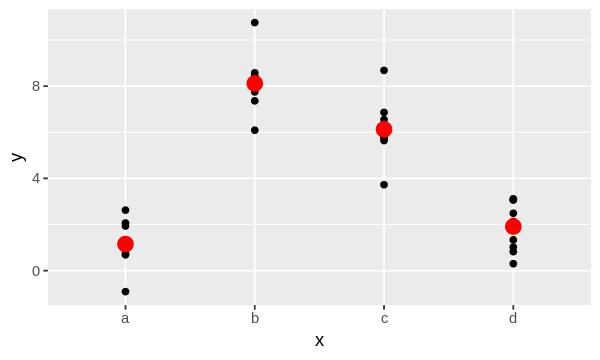

In [8]:
## PREDICTIONS VISUALIESIEREN: kategorisch
t(sim2)
grid <- sim2 %>%
  data_grid(x) %>%
  add_predictions(mod2)

ggplot(sim2, aes(x)) +
  geom_point(aes(y = y)) +
  geom_point(data = grid, aes(y = pred), color = "red", size=4)

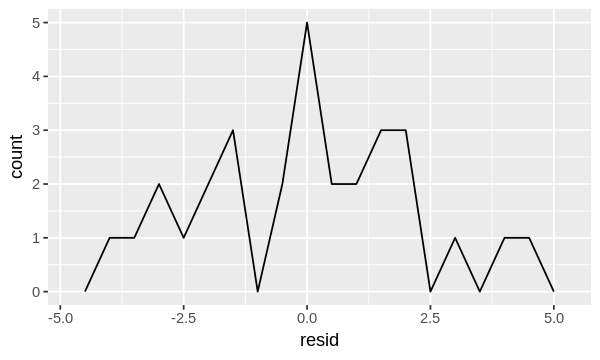

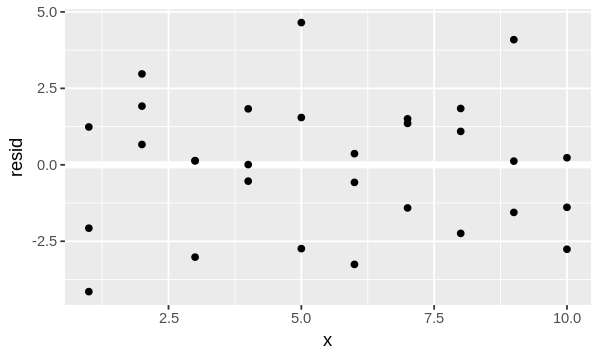

In [26]:
### RESIDUEN VISUALISIEREN
# => was hat das Modell nicht erfasst

sim1 <- sim1 %>% 
    add_residuals(sim1_mod)   # Residuen hinzufügen
# => orginales Datenset anstatt grid, weil y Werte benötigt

## Residuen-Verteilung Frequency-Plot (als alterntive zu Histogram)
ggplot(sim1, aes(resid)) + 
    geom_freqpoly(binwidth = 0.5)

## Residuals vs. Predictor Plot
ggplot(sim1, aes(x, resid)) +
  geom_ref_line(h = 0) +
  geom_point()


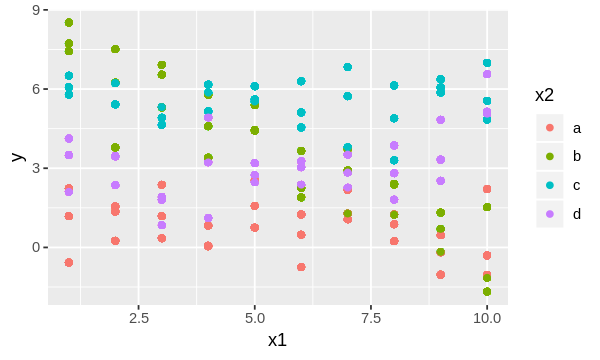

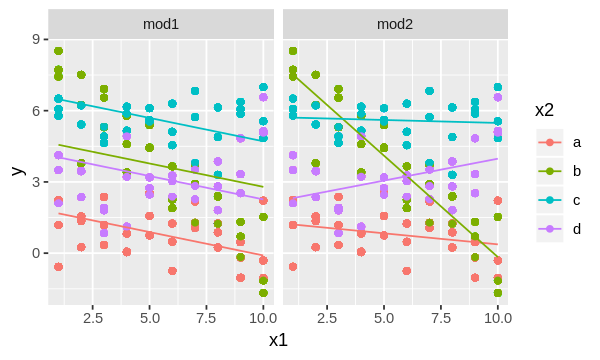

In [51]:
### INTERAKTIONEN
# * :  Interaktion als auch einzeln im Modell
# => y ~ x1 * x2  wird zu y = a_0 + a_1 * a1 + a_2 * a2 + a_12 * a1 * a2.
# 
## Kategorisch und kontinuierlich
#sim3
ggplot(sim3, aes(x1, y, color=x2)) +
  geom_point()

### Zwei mögliche Modelle
## Parallel slopes model
mod1 <- lm(y ~ x1 + x2, data=sim3)  # als jeweils unabhänige Variable
 
## Unteschiedlich Slopes => Interaktionen
mod2 <- lm(y ~ x1 * x2, data=sim3)  # fitten die Interaktion + einzeln 

#summary(mod1); summary(mod2)

## Predictions der Modelle vergleichen
grid <- sim3 %>%
  data_grid(x1, x2) %>%
  gather_predictions(mod1, mod2)

ggplot(sim3, aes(x1, y, color = x2)) +
  geom_point() +
  geom_line(data = grid, aes(y = pred)) +
  facet_wrap(~ model)

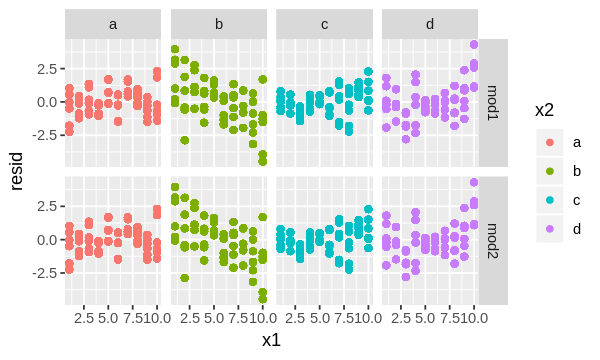

In [46]:
## Residuals der Modelle bzgl. der Kategorien vergleichen
sim3 <- sim3 %>%
  gather_residuals(mod1, mod2)

sim3 <- sim3[,2:dim(sim3)[2]]

ggplot(sim3, aes(x1, resid, color = x2)) +
  geom_point() +
  facet_grid(model ~ x2)
## => in mod1 wurde ein Pattern in b, c und d nicht erfasst!!!

In [ ]:
### MODEL MATRIX & TRANSFORMATIONEN
## Transformationen
#  I() benutzen, wenn Transformation +, *, ^, - enthält
#  y ~ x + I(x^2)   =>  y = a_1 + a_2 * x + a_3 * x^2
#  y ~ x + x^2      =>  Interaktion mit sich selbst was dasselbse wie x ist

model_matrix(mtcars, mpg ~ disp + disp^2) 
model_matrix(mtcars, mpg ~ disp + I(disp^2))